<a href="https://colab.research.google.com/github/jeffersonquispe/MachineTraslationAttention/blob/master/Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Traslation Francais to English 



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string 
import re
import random

import torch
import torch.nn as nn
from torch import  optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device


device(type='cuda')

Loading data files

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2020-07-02 23:04:56--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.178.72, 143.204.178.32, 143.204.178.104, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.178.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  5.24MB/s    in 0.5s    

2020-07-02 23:04:57 (5.24 MB/s) - ‘data.zip.1’ saved [2882130/2882130]



In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/eng-fra.txt        
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Arabic.txt   
replace data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Chinese.txt  
replace data/names/Czech.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/names/Czech.txt    
replace data/names/Dutch.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/na

In [ ]:
 !wget https://www.manythings.org/anki/spa-eng.zip

--2020-07-02 23:12:41--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 172.67.173.198, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4803040 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip.1’

spa-eng.zip.1       100%[===================>]   4.58M  4.88MB/s    in 0.9s    

2020-07-02 23:12:42 (4.88 MB/s) - ‘spa-eng.zip.1’ saved [4803040/4803040]



In [ ]:
!unzip spa-eng.zip

Archive:  spa-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: _about.txt              
  inflating: spa.txt                 


In [ ]:
!head spa.txt

Go.	Ve.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
Go.	Vete.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
Go.	Vaya.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
Go.	Váyase.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
Hi.	Hola.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)
Run!	¡Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)
Run!	¡Corran!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)
Run!	¡Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)
Run!	¡Corred!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)
Run.	Corred.	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #6681472 (arh)


In [ ]:
!head data/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


In [ ]:
SOS_token=0 #start sentence
EOS_token=1 #end sentence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    lines=open('spa.txt', encoding='utf-8').read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
input_lang, output_lang, pairs=readLangs('eng','fra',True)

Reading lines...


In [ ]:
pairs[:10]

[['ve .', 'go .'],
 ['vete .', 'go .'],
 ['vaya .', 'go .'],
 ['vayase .', 'go .'],
 ['hola .', 'hi .'],
 [' corre !', 'run !'],
 [' corran !', 'run !'],
 [' corra !', 'run !'],
 [' corred !', 'run !'],
 ['corred .', 'run .']]

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'spa', True)
print(random.choice(pairs))

Reading lines...
Read 124325 sentence pairs
Trimmed to 7690 sentence pairs
Counting words...
Counted words:
spa 3880
eng 2686
['el es el dueno legal de la empresa .', 'he is the lawful owner of the company .']


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
ws=random.choice(pairs)
ts=tensorsFromPair(ws)
print(ws)
print(ts)

['te estoy suplicando .', 'i m begging you .']
(tensor([[436],
        [  5],
        [782],
        [  4],
        [  1]], device='cuda:0'), tensor([[  2],
        [  3],
        [507],
        [ 74],
        [  4],
        [  1]], device='cuda:0'))


In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #decoder_attentions[di] = decoder_attention.data
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 23s (- 19m 22s) (5000 6%) 3.1474
2m 38s (- 17m 13s) (10000 13%) 2.5355
3m 55s (- 15m 40s) (15000 20%) 2.1857
5m 11s (- 14m 16s) (20000 26%) 1.8383
6m 28s (- 12m 56s) (25000 33%) 1.5806
7m 45s (- 11m 37s) (30000 40%) 1.3831
9m 2s (- 10m 20s) (35000 46%) 1.1838
10m 20s (- 9m 2s) (40000 53%) 1.0535
11m 37s (- 7m 45s) (45000 60%) 0.8992
12m 54s (- 6m 27s) (50000 66%) 0.7934
14m 11s (- 5m 9s) (55000 73%) 0.6896
15m 28s (- 3m 52s) (60000 80%) 0.6021
16m 45s (- 2m 34s) (65000 86%) 0.5095
18m 1s (- 1m 17s) (70000 93%) 0.4616
19m 17s (- 0m 0s) (75000 100%) 0.3663


<Figure size 432x288 with 0 Axes>

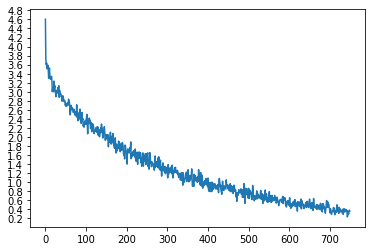

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
decoder1 = DecoderRNN(hidden_size,input_lang.n_words).to(device)

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, decoder1)


> ahora estoy muy cansado .
= i m very tired now .
< i m very tired now . <EOS>

> estamos progresando .
= we re making progress .
< we re making progress . <EOS>

> me caso la proxima semana .
= i m getting married next week .
< i m getting married next week . <EOS>

> nos mudamos .
= we re moving .
< we re moving . <EOS>

> estoy un poco enojado contigo .
= i m a little angry with you .
< i m a little angry with you . <EOS>

> estoy en la cima del mundo .
= i m on top of the world .
< i m on the of the the world . <EOS>

> el es un estudiante universitario .
= he is a university student .
< he is a university student . <EOS>

> estoy un poco ido .
= i m a little crazy .
< i m a little crazy . <EOS>

> el tiene la culpa del fracaso .
= he is to blame for the failure .
< he is to blame for the failure . <EOS>

> esta acostumbrado a trabajar duro .
= he is used to hard work .
< he is used to hard work . <EOS>



In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)